In [6]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

## Dataset escolhido

O dataset escolhido foi o Série Temporal Preço do Boi Gordo:
https://www.kaggle.com/datasets/maiconserrao/serie-temporal-peso-do-gado

In [3]:
df = pd.read_csv('/content/data.csv')

## Descrição das Colunas do Dataset:

In [4]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,31.07.2023,"178,05","178,35","178,65","176,80","10,75K","-0,06%"
1,28.07.2023,"178,15","178,45","179,07","178,00","9,26K","0,06%"
2,27.07.2023,"178,05","178,78","178,93","177,95","6,60K","-0,35%"
3,26.07.2023,"178,68","178,25","178,97","177,88","5,87K","0,21%"
4,25.07.2023,"178,30","179,45","179,60","177,90","8,34K","-0,25%"


**Data:** Data do registro do preço do "Boi Gordo", no formato dia/mês/ano.

**Último:** Preço final registrado para o "Boi Gordo" na data específica.

**Abertura:** Preço de abertura do "Boi Gordo" na data específica.

**Máxima:** Preço máximo registrado durante o dia.

**Mínima:** Preço mínimo registrado durante o dia.

**Vol:** Volume de negociações do "Boi Gordo" na data.

**Var%:** Variação percentual do preço do "Boi Gordo" em comparação com o dia anterior.

In [5]:
df.describe()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,3306,3306,3306,3306,3306,3261,3306
unique,3306,1825,1775,1822,1826,1971,567
top,31.07.2023,"120,00","122,00","126,72","125,50","2,08K","0,00%"
freq,1,8,11,9,10,9,50


## Implementação do Modelo RNN para Previsão

### Conversão para date-time

In [10]:
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')

### Normalização da coluna last
- A coluna 'Last' é selecionada para a predição.
- Os dados são normalizados para ficarem entre 0 e 1.

In [12]:
df['Último'] = df['Último'].str.replace(',', '.').astype(float)

prices = df['Último'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

### Criando sequências para treino
O modelo é alimentado com janelas de tempo de 60 dias, tentando prever o próximo valor.

In [13]:
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(window_size, len(data)):
        sequences.append(data[i-window_size:i, 0])
        labels.append(data[i, 0])
    return np.array(sequences), np.array(labels)

window_size = 60  # Exemplo de janela de 60 dias
X, y = create_sequences(scaled_prices, window_size)


### Treino e teste

In [14]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [15]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Modelo RNN
Uma RNN com duas camadas LSTM é usada.

In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Treinamento

In [18]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0312 - val_loss: 7.2163e-04
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0014 - val_loss: 7.8604e-04
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0013 - val_loss: 6.6010e-04
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0012 - val_loss: 6.5641e-04
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0012 - val_loss: 5.6778e-04
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0011 - val_loss: 6.2392e-04
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0011 - val_loss: 5.5926e-04
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 9.7802e-04 - val_loss: 4.6796e-04
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 8.0608e-04 - val_loss: 4.3478e-04
Epoch 10/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 6.6267e-04 - val_loss: 4.2722e-04
Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 7.0155e-04 - val_loss: 3.7719e-04
Epo

### Predições

In [19]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


### Desempenho com MSE

In [20]:
mse = mean_squared_error(y_test_rescaled, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2.8203013745538916


### Escolha de Métrica:

O MSE mede a diferença quadrada média entre os valores reais e os valores previstos, penalizando grandes desvios. Como estamos lidando com valores numéricos contínuos (preços), o MSE é apropriado porque ajuda a medir o desempenho do modelo considerando a magnitude dos erros.

### Valor real e o valor predito

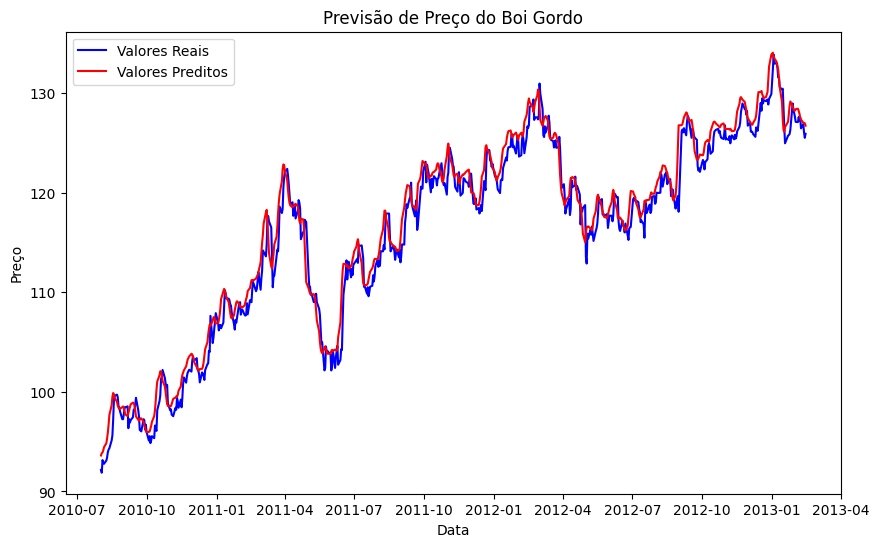

In [21]:
plt.figure(figsize=(10,6))
plt.plot(df['Data'][-len(y_test):], y_test_rescaled, color='blue', label='Valores Reais')
plt.plot(df['Data'][-len(predictions):], predictions, color='red', label='Valores Preditos')
plt.title('Previsão de Preço do Boi Gordo')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()